In [1]:
using QuantumOptics
using IonSim
import PyPlot
const plt = PyPlot;

$\hat{H} = \frac{\Omega(t)}{2} \sum_{i=1,2} \Bigg[ \bigg( \hat{\sigma}_+^{(1)} + \hat{\sigma}_+^{(2)} \bigg) \otimes e^{i[\eta(\hat{a} e^{-i\nu t} + \hat{a}^\dagger e^{i \nu t} ) - \Delta_i t + \phi_i ) ] } \Bigg] + h.c.$

We wish to scan over:
1. Intensity
2. Detuning
    
    a. Trapping frequency

    b. B-field (strength)

    c. Laser frequency

## 1. Set up the trap

In [341]:
# Construct the system
ca = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
ion1 = ca
ion2 = ca

‚Å¥‚Å∞Ca

In [342]:
chain = LinearChain(
        ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


LinearChain(2 ions)

In [343]:
#################### Chamber-independent laser properties ####################
timescale = 1e-6

DETUNING = 1e4 
GATE_TIME = 1/DETUNING # seconds

laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
# B-field polarized between x and z. That has something to do with our
# choice of polarization and wavevector, but not 100% sure of the relation
laser1.œµ = xÃÇ
laser1.k = zÃÇ

laser2.œµ = xÃÇ
laser2.k = zÃÇ

#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################
wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)
print("laser1.Œª: ", laser1.Œª)

vibrational_mode = modes(chamber)[1]
ŒΩ = frequency(vibrational_mode)

d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
Œî_blue = ŒΩ + DETUNING - d# <-- This is the "sideband detuning", which depends on the gate-time detuning but is not the same thing
Œî_red = -(ŒΩ + DETUNING - d)

laser1.Œî = Œî_blue # blue sideband
laser2.Œî = Œî_red; # red sideband


laser1.Œª: 7.291469940286195e-7

## 2. Intensity scan

In [344]:
function get_bell_state_fidelity(state)
    rho = dm(state)
    rho_electronic = ptrace(rho, 3)
    fid = fidelity(rho_electronic, BELL_STATE_ELECTRONIC)
    return fid 
end

function get_entanglement_entropy(œÅ)
    œÅ_red = ptrace(œÅ, 3)
    S = entropy_vn(œÅ_red)
    return S
end

# Initial state
œà0_electronic = ca["S"] ‚äó ca["S"]
œà0_motional = vibrational_mode[0]
œà0 = œà0_electronic ‚äó œà0_motional

# Bell state to which we compare
BELL_STATE_ELECTRONIC = dm((ca["S"] ‚äó ca["S"] + 1im * ca["D"] ‚äó ca["D"])/‚àö2);

In [345]:
# intensity_from_pitime to get rough estimate of the range over which to scan
Œ∑ = abs(lambdicke(vibrational_mode, ca, laser1))
I_pitime = intensity_from_pitime(1, Œ∑ / DETUNING , 1, ("S", "D"), chamber)
I_range = 0:I_pitime*1e-2:I_pitime*1.5

timescale = 1e-6
t_range = 0:GATE_TIME*1e-3:GATE_TIME

fidelities = zeros(length(I_range))
entanglement_entropies = zeros(length(I_range))
idx = Int(0)
for I in I_range
    idx += 1

    intensity!(laser1, I)
    intensity!(laser2, I)

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

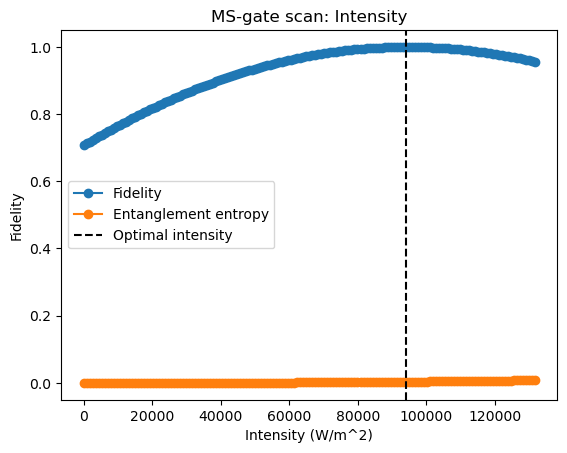

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Calibrated intensity = 93975.34935500399 W/m^2 
Max fidelity = 0.9997913846503805
Entanglement entropy at max fidelity = 0.0035837530041411933


In [346]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
I_optimal = I_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")

print("\nCalibrated intensity = ", I_optimal, " W/m^2 \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(I_range, fidelities, "o-", label = "Fidelity")
plt.plot(I_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=I_optimal, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Intensity (W/m^2)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: Intensity")
plt.legend()
plt.display(fig)
plt.close()

Plot %-change in intensity (wrt I_optimal) vs fidelity

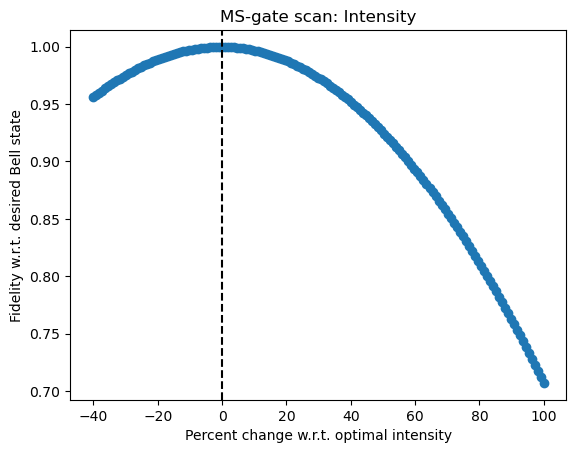

In [347]:
percent_change_intensity = 100 .*(I_optimal .- I_range)/I_optimal

fig = plt.figure()
plt.plot(percent_change_intensity, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent change w.r.t. optimal intensity")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: Intensity")
plt.display(fig)

Set the optimal intensity so we can start scanning the other parameters

In [350]:
INTENSITY = I_optimal
intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY)

#33 (generic function with 1 method)

Keeping track of global parameters:
- DETUNING (ideal)
- GATE_TIME
- INTENSITY

In [398]:
I_optimal

93975.34935500399

In [397]:
I_pitime

87827.42930374204

## 3. Detuning (actual): Trapping frequency

TODO: Include diagram from Sara meeting

Trap-frequency fluctuation $\Longleftrightarrow$ all reds spread (positive change) or squeeze (negative change)

In [364]:
ŒΩ_target = 2.5e5
ŒΩ_range = ŒΩ_target*1e-1:ŒΩ_target*1e-2:ŒΩ_target*2

fidelities = zeros(length(ŒΩ_range))
entanglement_entropies = zeros(length(ŒΩ_range))
idx = Int(0)
for ŒΩ_actual in ŒΩ_range
    idx += 1

    chain = LinearChain(
        ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6, z=ŒΩ_actual ), selectedmodes=(;z=[1],)
    )
    
    laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
    laser1.œµ = xÃÇ
    laser1.k = zÃÇ

    laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
    laser2.œµ = xÃÇ
    laser2.k = zÃÇ

    #################### Chamber ####################
    chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

    #################### Chamber-dependent laser properties ####################
    wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
    wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)

    d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
    Œî_blue = ŒΩ_target + DETUNING - d# <-- This is the "sideband detuning", which depends on the gate-time detuning but is not the same thing
    Œî_red = -(ŒΩ_target + DETUNING - d)

    laser1.Œî = Œî_blue # blue sideband
    laser2.Œî = Œî_red; # red sideband

    intensity!(laser1, I_optimal)
    intensity!(laser2, I_optimal)

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end



‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94
‚îå Warning: Some ions point to the same 

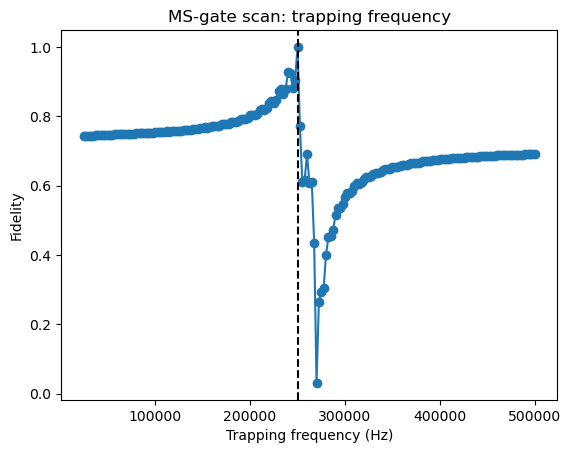

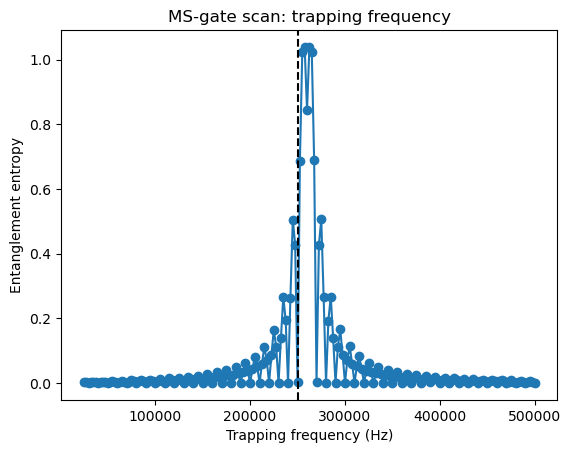

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Intensity = 93975.34935500399 W/m^2 

Calibrated trapping frequency = 250000.0 Hz 
Max fidelity = 0.9997913846503805
Entanglement entropy at max fidelity = 0.0035837530041411933


In [366]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
ŒΩ_optimal = ŒΩ_range[max_fidel_idx[1]]


print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Intensity = ", INTENSITY, " W/m^2 \n")

print("\nCalibrated trapping frequency = ", ŒΩ_optimal, " Hz \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(ŒΩ_range, fidelities, "o-", label = "Fidelity")
plt.axvline(x=ŒΩ_optimal, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Trapping frequency (Hz)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: trapping frequency")
plt.display(fig)
plt.close()

fig = plt.figure()
plt.plot(ŒΩ_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=ŒΩ_optimal, color="black", linestyle="--", label="Optimal intensity")
plt.xlabel("Trapping frequency (Hz)")
plt.ylabel("Entanglement entropy")
plt.title("MS-gate scan: trapping frequency")
plt.display(fig)
plt.close()


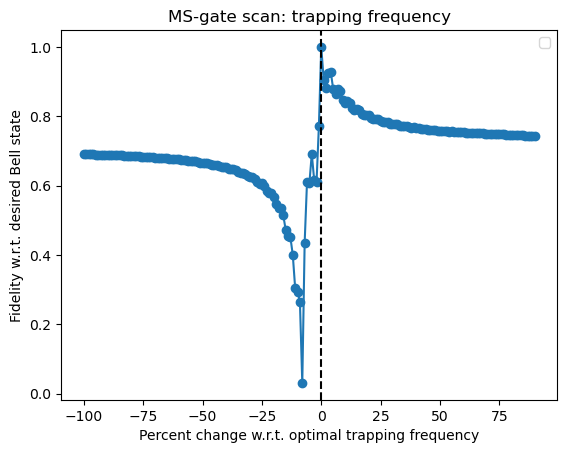

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [367]:
percent_change_tf = 100 .*(ŒΩ_optimal .- ŒΩ_range)/ŒΩ_optimal

fig = plt.figure()
plt.plot(percent_change_tf, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent change w.r.t. optimal trapping frequency")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: trapping frequency")
plt.legend()
plt.display(fig)

In [395]:
ŒΩ_optimal

250000.0

In [396]:
ŒΩ_target

250000.0

I suppose it makes sense that $\nu_{\text{optimal}} = \nu_{\text{mean}}$ - the intensity was calibrated for $\nu_{\text{mean}}$.

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


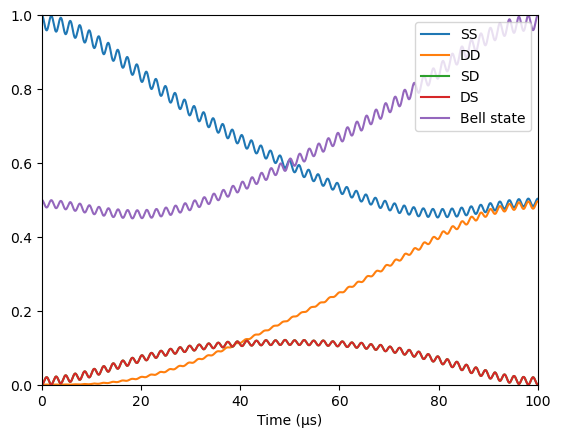

  0.099775 seconds (1.76 M allocations: 67.441 MiB, 5.61% gc time)
Bell-state fidelity: 0.9997913846503805
Electronic-Motional entanglement entropy: 0.0035837530041411933 + 0.0im


In [368]:
chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=ŒΩ_mean ), selectedmodes=(;z=[1],)
)

    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
laser1.œµ = xÃÇ
laser1.k = zÃÇ

laser2.œµ = xÃÇ
laser2.k = zÃÇ

#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################
wavelength_from_transition!(laser1, ca, ("S", "D"), chamber)
wavelength_from_transition!(laser2, ca, ("S", "D"), chamber)

d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
Œî_blue = ŒΩ_mean + DETUNING - d# <-- This is the "sideband detuning", which depends on the gate-time detuning but is not the same thing
Œî_red = -(ŒΩ_mean + DETUNING - d)

laser1.Œî = Œî_blue # blue sideband
laser2.Œî = Œî_red; # red sideband

intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY)
h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=Inf);
# solve system
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

SS = ionprojector(chamber, "S", "S") 
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ‚äó ca["S"] + 1im * ca["D"] ‚äó ca["D"])/‚àö2) ‚äó one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # ùîº(|S‚ü©|S‚ü©)
prob_DD = expect(DD, sol)  # ùîº(|D‚ü©|D‚ü©)
prob_SD = expect(SD, sol)  # ùîº(|S‚ü©|D‚ü©)
prob_DS = expect(DS, sol)  # ùîº(|D‚ü©|S‚ü©)
prob_bell = expect(bell_state, sol)  # ùîº((|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)/‚àö2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (Œºs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")


In [369]:
TRAPPING_FREQUENCY = ŒΩ_optimal

250000.0

Keeping track of global parameters:
- DETUNING (ideal)
- GATE_TIME
- INTENSITY
- TRAPPING_FREQUENCY

## 4. Detuning (actual)

Laser frequency fluctuation $\Longleftrightarrow$ all greens shift (same direction, same amount)

### 4.a. Determining reasonably-computable orders-of-magnitude for fluctuations in the laser wavelength

Computing the Hamiltonian for a given laser frequency shift to arbitray order is computationally intractable, so we have to choose:
1. An RWA cutoff
    a. We choose $\texttt{RWA\_CUTOFF = 1e20}$ somewhat arbitrarily
2. An absolute maximum fluctuation in the laser wavelength. We find $\delta \lambda\_\texttt{MAX}$ empirically (see cell $\texttt{4.a.i}$ below). 

Interestingly enough, we don't get the same result when varying the laser-detuning $\texttt{laser.}\Delta$ vs. the laser-wavelength $\texttt{laser.}\lambda$, i.e. choosing $\delta \lambda = c/\delta f$ or vice-versa (compare cells $\texttt{4.a.i}$ and $\texttt{4.a.ii}$ below). They're certainly different parameters in the IonSim master equation, but varying either one should correspond to the same (or at least similar) physical behavior (if my understanding of the $\texttt{laser.}\lambda$ and $\texttt{laser.}\Delta$ parameters is correct)

$\textbf{TODO:}$ Figure out why this is.

4.a.i. Varying wavelength $\texttt{laser.}\lambda$

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


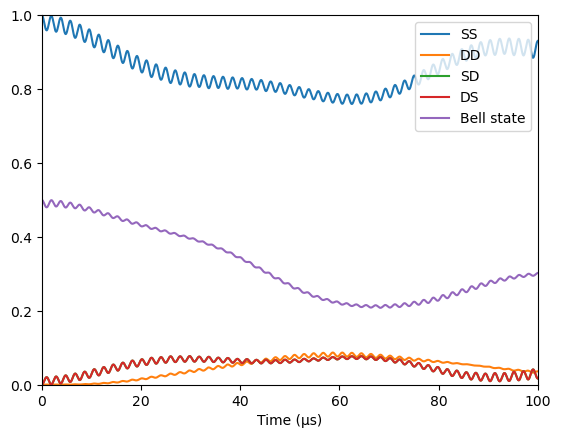

  0.131209 seconds (1.74 M allocations: 66.441 MiB, 10.73% gc time)
Bell-state fidelity: 0.5499414657427376
Electronic-Motional entanglement entropy: 0.1543687021453811 + 0.0im


1.0e-15

In [370]:
RWA_CUTOFF = 1e20

chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
laser1.œµ = xÃÇ
laser1.k = zÃÇ

laser2.œµ = xÃÇ
laser2.k = zÃÇ

intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY);

######################################## Detuning/Wavelength stuff ########################################

Œª_target = transitionwavelength(ca, ("S", "D"), chamber)

Œî_blue = TRAPPING_FREQUENCY + DETUNING - d 
Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d )

laser1.Œî = Œî_blue # blue sideband
laser2.Œî = Œî_red; # red sideband


#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################

# Setting Œ¥Œª directly
Œ¥Œª = -1e-17 # \pm 1e-15 is the LARGEST order-of-magnitude that terminates reasonably and doesn't give a trivial result (i.e. just straight horizontal lines)
wavelength!(laser1, Œª_target + Œ¥Œª)
wavelength!(laser2, Œª_target + Œ¥Œª)

# # Setting Œ¥Œª as a fraction of Œª_target
# Œ¥Œª = Œª_target*1e-9 # \pm Œª_target*1e-9 is the LARGEST OOM that terminates reasonably and doesn't give a trivial result
# wavelength!(laser1, Œª_target - Œ¥Œª)
# wavelength!(laser2, Œª_target - Œ¥Œª)

# # Setting Œ¥f as a fraction of f_target, then Œ¥Œª = c0/Œ¥f
# c0 = 2.99792458e8
# f_target = c0/Œª_target
# Œ¥f = f_target*1e9 # 1e9 is the SMALLEST OOM that terminates reasonably and doesn't give a trivial result
# Œ¥Œª = -c0/Œ¥f
# wavelength!(laser1, Œª_target + Œ¥Œª)
# wavelength!(laser2, Œª_target + Œ¥Œª)

# # No fluctuation
# wavelength!(laser1, Œª_target)
# wavelength!(laser2, Œª_target)

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ‚äó ca["S"] + 1im * ca["D"] ‚äó ca["D"])/‚àö2) ‚äó one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # ùîº(|S‚ü©|S‚ü©)
prob_DD = expect(DD, sol)  # ùîº(|D‚ü©|D‚ü©)
prob_SD = expect(SD, sol)  # ùîº(|S‚ü©|D‚ü©)
prob_DS = expect(DS, sol)  # ùîº(|D‚ü©|S‚ü©)
prob_bell = expect(bell_state, sol)  # ùîº((|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)/‚àö2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (Œºs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")

Œ¥Œª_MAX = 1e-15


4.a.ii. Varying detuning $\texttt{laser.}\Delta$

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


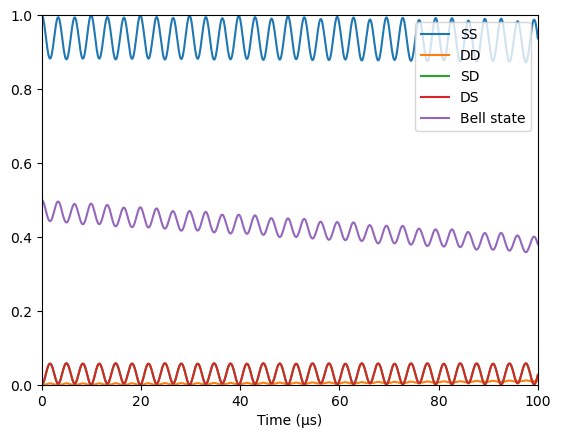

  0.092124 seconds (1.59 M allocations: 61.043 MiB, 7.75% gc time)
Bell-state fidelity: 0.6166353354899833
Electronic-Motional entanglement entropy: 0.004005969531643849 + 0.0im


In [371]:
chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity

# Set polarizations, wavevectors
laser1.œµ = xÃÇ
laser1.k = zÃÇ

laser2.œµ = xÃÇ
laser2.k = zÃÇ

intensity!(laser1, INTENSITY)
intensity!(laser2, INTENSITY);

######################################## Detuning/Wavelength stuff ########################################

Œª_target = transitionwavelength(ca, ("S", "D"), chamber)

# Setting Œ¥f directly
# Œ¥f = 1e5 # \pm 1e5 is the LARGEST OOM that terminates reasonably and doesn't give a trivial result. Corresponds to Œ¥Œª=c0/Œ¥f \sim 3e3  
# d = 0
# Œî_blue = TRAPPING_FREQUENCY + DETUNING - d + Œ¥f 
# Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d + Œ¥f)

# Setting Œ¥f as a fraction of f_target
# c0 = 2.99792458e8
# f_target = c0/Œª_target
# Œ¥f = -f_target*1e-9 # 1e-9 is the LARGEST oom that terminates reasonably and doesn't give a trivial result
# d = 0
# Œî_blue = TRAPPING_FREQUENCY + DETUNING - d + Œ¥f 
# Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d + Œ¥f)


# Setting Œ¥Œª as a fraction of Œª_target, then Œ¥f = c0/Œ¥Œª
c0 = 2.99792458e8
Œ¥Œª = Œª_target*1e9 # \pm Œª_target*1e9 is the SMALLEST OOM that terminates reasonably and doesn't give a trivial result
Œ¥f = -c0/Œ¥Œª
d = 0
Œî_blue = TRAPPING_FREQUENCY + DETUNING - d + Œ¥f 
Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d + Œ¥f)

# No fluctuation
# d = 0
# Œî_blue = TRAPPING_FREQUENCY + DETUNING - d 
# Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d )


laser1.Œî = Œî_blue # blue sideband
laser2.Œî = Œî_red; # red sideband


#################### Chamber ####################
chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################

wavelength!(laser1, Œª_target)
wavelength!(laser2, Œª_target)

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ‚äó ca["S"] + 1im * ca["D"] ‚äó ca["D"])/‚àö2) ‚äó one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # ùîº(|S‚ü©|S‚ü©)
prob_DD = expect(DD, sol)  # ùîº(|D‚ü©|D‚ü©)
prob_SD = expect(SD, sol)  # ùîº(|S‚ü©|D‚ü©)
prob_DS = expect(DS, sol)  # ùîº(|D‚ü©|S‚ü©)
prob_bell = expect(bell_state, sol)  # ùîº((|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)/‚àö2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (Œºs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")

## 4.b Running laser-wavelength scan

In [372]:
Œª_target = transitionwavelength(ca, ("S", "D"), chamber)
Œ¥Œª_MAX = 1e-15
Œ¥Œª_power_range = -25:0.1:-15
Œ¥Œª_range = 10 .^ Œ¥Œª_power_range
Œª_plus_range = Œª_target .+ Œ¥Œª_range
Œª_minus_range = Œª_target .- Œ¥Œª_range
Œª_range = vcat(Œª_minus_range, Œª_plus_range)
length(Œª_range)

202

In [373]:
Œª_target = transitionwavelength(ca, ("S", "D"), chamber)
Œ¥Œª_MAX = 1e-15
Œ¥Œª_power_range = -25:0.1:-15
Œ¥Œª_range = 10 .^ Œ¥Œª_power_range
Œª_plus_range = Œª_target .+ Œ¥Œª_range
Œª_minus_range = Œª_target .- Œ¥Œª_range
Œª_range = vcat(Œª_minus_range, Œª_plus_range)

fidelities = zeros(length(Œª_range))
entanglement_entropies = zeros(length(Œª_range))
idx = Int(0)
for Œª_actual in Œª_range
    idx += 1

    #################### Chamber ####################
    chamber = Chamber(iontrap=chain, B=6e-4, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

    #################### Chamber-dependent laser properties ####################

    d = 0 #350 # corrects for AC stark shift from single-photon coupling to sidebands
    Œî_blue = TRAPPING_FREQUENCY + DETUNING - d 
    Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d)

    laser1.Œî = Œî_blue # blue sideband
    laser2.Œî = Œî_red; # red sideband

    intensity!(laser1, INTENSITY)
    intensity!(laser2, INTENSITY)

    wavelength!(laser1, Œª_actual)
    wavelength!(laser2, Œª_actual)

    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end



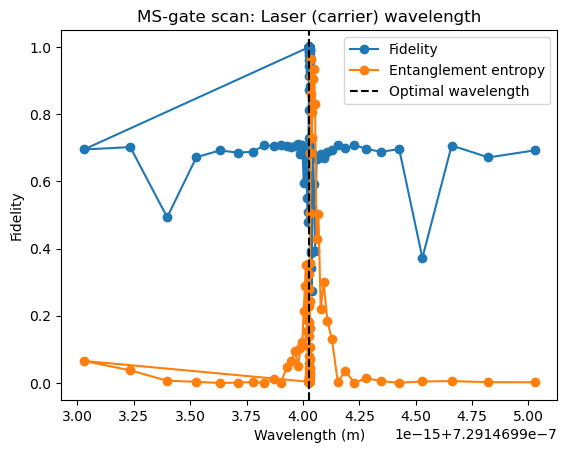

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 

Calibrated wavelength= 7.291469940286511e-7 W/m^2 
Max fidelity = 0.9998161509453058
Entanglement entropy at max fidelity = 0.002903568196670668


In [378]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
Œª_optimal = Œª_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("\nIntensity = ", INTENSITY, " W/m^2 \n")
print("Trapping frequency = ", TRAPPING_FREQUENCY, " Hz \n")

print("\nCalibrated wavelength= ", Œª_optimal, " W/m^2 \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(Œª_range, fidelities, "o-", label = "Fidelity")
plt.plot(Œª_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=Œª_optimal, color="black", linestyle="--", label="Optimal wavelength")
plt.xlabel("Wavelength (m)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.legend()
plt.display(fig)
plt.close()

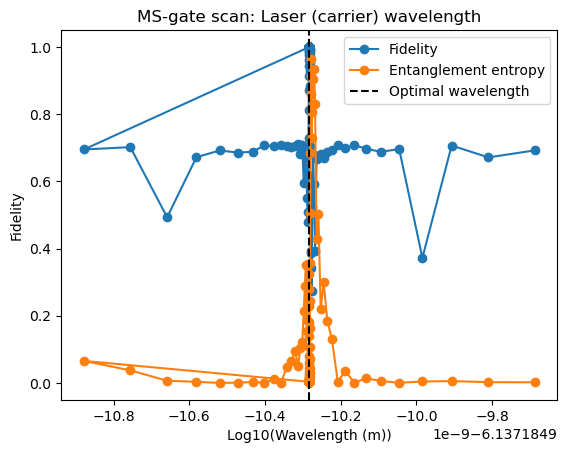

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s

Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 

Calibrated wavelength= 7.291469940286511e-7 W/m^2 
Max fidelity = 0.9998161509453058
Entanglement entropy at max fidelity = 0.002903568196670668


In [386]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
Œª_optimal = Œª_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("\nIntensity = ", INTENSITY, " W/m^2 \n")
print("Trapping frequency = ", TRAPPING_FREQUENCY, " Hz \n")

print("\nCalibrated wavelength= ", Œª_optimal, " m \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(broadcast(log10, Œª_range), fidelities, "o-", label = "Fidelity")
plt.plot(broadcast(log10, Œª_range), entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=log10(Œª_optimal), color="black", linestyle="--", label="Optimal wavelength")
plt.xlabel("Log10(Wavelength (m))")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.legend()
plt.display(fig)
plt.close()

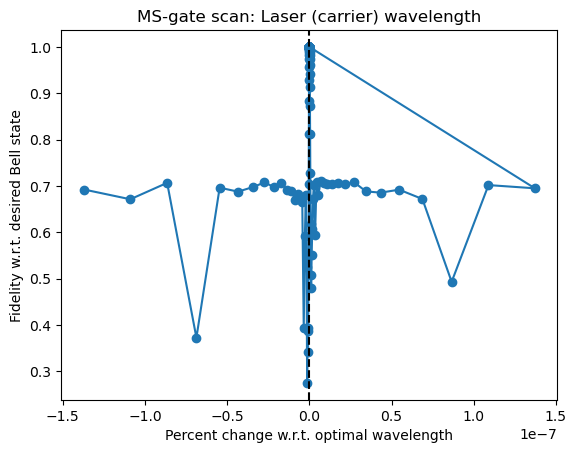

In [375]:
percent_change_wavelength = 100 .*(Œª_optimal .- Œª_range)/Œª_optimal

fig = plt.figure()
plt.plot(percent_change_wavelength, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent change w.r.t. optimal wavelength")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.display(fig)

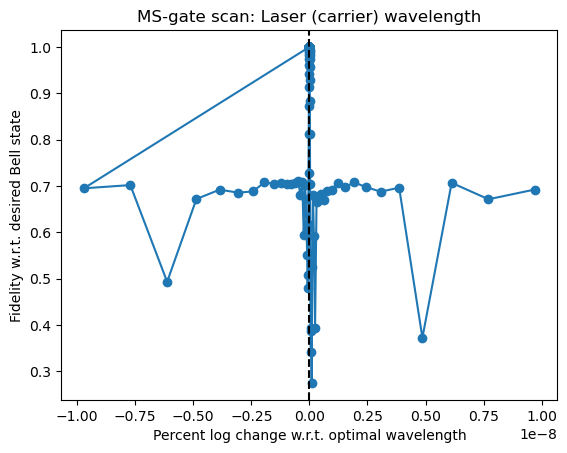

In [389]:
log_Œª_range = broadcast(log10, Œª_range)
percent_change_log_wavelength = 100 .*(log10(Œª_optimal) .- log_Œª_range)/log10(Œª_optimal)

fig = plt.figure()
plt.plot(percent_change_log_wavelength, fidelities, "o-")
plt.axvline(x=0, color="black", linestyle="--")
plt.xlabel("Percent log change w.r.t. optimal wavelength")
plt.ylabel("Fidelity w.r.t. desired Bell state")
plt.title("MS-gate scan: Laser (carrier) wavelength")
plt.display(fig)

Keeping track of global parameters:
- DETUNING (ideal)
- GATE_TIME
- INTENSITY
- TRAPPING_FREQUENCY
- LASER_WAVELENGTH

In [390]:
LASER_WAVELENGTH = Œª_optimal

7.291469940286511e-7

In [391]:
Œª_optimal

7.291469940286511e-7

In [392]:
Œª_target

7.291469940286195e-7

## 5. Finally, scan the magnetic field strength

In [425]:
chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser1.œµ = xÃÇ
laser1.k = zÃÇ
intensity!(laser1, INTENSITY)
wavelength!(laser1, LASER_WAVELENGTH)

laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
laser2.œµ = xÃÇ
laser2.k = zÃÇ
intensity!(laser2, INTENSITY)
wavelength!(laser2, LASER_WAVELENGTH)

d = 0
Œî_blue = TRAPPING_FREQUENCY + DETUNING - d 
Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d )
laser1.Œî = Œî_blue # blue sideband
laser2.Œî = Œî_red; # red sideband

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


In the future: fast fluctuations and polarization direction?

TODO: Setting $\texttt{chamber.B = B + } \delta \texttt{B}$ gives similar, but not exactly the same, result as setting $\texttt{chamber.}\delta\texttt{B = }\delta\texttt{B}$.

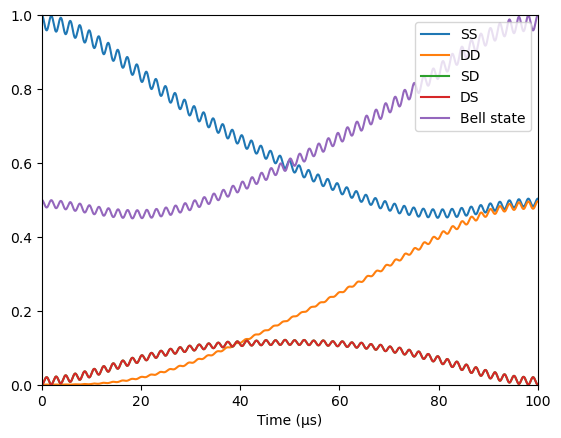

  0.106633 seconds (1.76 M allocations: 67.441 MiB, 9.15% gc time)
Bell-state fidelity: 0.9998161509453058
Electronic-Motional entanglement entropy: 0.002903568196670668 + 0.0im


In [426]:
Œ¥B = 0# 1e-7 # Pretty much as large as idx can go before the simulation becomes too slow

chamber = Chamber(iontrap=chain, B=6e-4 + Œ¥B, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

#################### Chamber-dependent laser properties ####################

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ‚äó ca["S"] + 1im * ca["D"] ‚äó ca["D"])/‚àö2) ‚äó one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # ùîº(|S‚ü©|S‚ü©)
prob_DD = expect(DD, sol)  # ùîº(|D‚ü©|D‚ü©)
prob_SD = expect(SD, sol)  # ùîº(|S‚ü©|D‚ü©)
prob_DS = expect(DS, sol)  # ùîº(|D‚ü©|S‚ü©)
prob_bell = expect(bell_state, sol)  # ùîº((|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)/‚àö2)

# plot results
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (Œºs)");
plt.display(fig)

bs_fid = get_bell_state_fidelity(sol[end])
print("Bell-state fidelity: ", real(bs_fid), "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")

In [427]:
B_target = 6e-4
Œ¥B_MAX = 1e-4
Œ¥B_power_range = -10:0.1:-4
Œ¥B_range = 10 .^ Œ¥B_power_range
B_plus_range = B_target .+ Œ¥B_range
B_minus_range = B_target .- Œ¥B_range
B_range = vcat(B_minus_range, B_plus_range)
Œ¥B_range = B_target .- B_range

fidelities = zeros(length(B_range))
entanglement_entropies = zeros(length(B_range))
idx = Int(0)
for B_actual in B_range
    idx += 1

    #################### Chamber ####################
    chamber = Chamber(iontrap=chain, B=B_actual, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);
    h = hamiltonian(chamber, timescale=timescale, lamb_dicke_order=1, rwa_cutoff=Inf);
    tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

    final_state = sol[end]
    fid_i = get_bell_state_fidelity(final_state)
    S_i = get_entanglement_entropy(final_state)

    #@assert imag(fid) < 1e-8
    fidelities[idx] = real(fid_i)
    entanglement_entropies[idx] = S_i

end

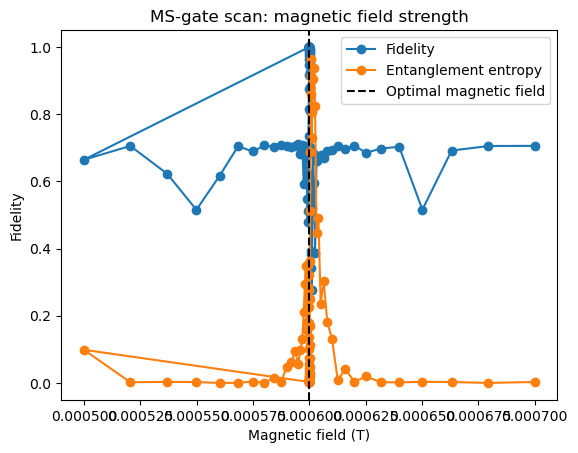

Results: 
Detuning = 10000.0 Hz 
Gate time = 0.0001 s
Intensity = 93975.34935500399 W/m^2 
Trapping frequency = 250000.0 Hz 
Laser (carrier) wavelength= 7.291469940286511e-7 m 

Calibrated magnetic field= 0.0005999998999999999 T 
Max fidelity = 0.9998161808711384
Entanglement entropy at max fidelity = 0.0029198516661979408


In [428]:
max_fidel_idx = findall(broadcast(abs, fidelities.-maximum(fidelities)) .< 1e-8)
max_fidel = fidelities[max_fidel_idx[1]]
min_ee = entanglement_entropies[max_fidel_idx[1]]
Œ¥B_optimal = Œ¥B_range[max_fidel_idx[1]]
B_optimal = B_range[max_fidel_idx[1]]

print("Results: \n")
print("Detuning = ", DETUNING, " Hz \n")
print("Gate time = ", GATE_TIME, " s\n")
print("Intensity = ", INTENSITY, " W/m^2 \n")
print("Trapping frequency = ", TRAPPING_FREQUENCY, " Hz \n")
print("Laser (carrier) wavelength= ", LASER_WAVELENGTH, " m \n")

print("\nCalibrated magnetic field= ", B_optimal, " T \n")
print("Max fidelity = ", max_fidel, "\n")
print("Entanglement entropy at max fidelity = ", min_ee, "\n")

fig = plt.figure()
plt.plot(B_range, fidelities, "o-", label = "Fidelity")
plt.plot(B_range, entanglement_entropies, "o-", label = "Entanglement entropy")
plt.axvline(x=B_optimal, color="black", linestyle="--", label="Optimal magnetic field")
plt.xlabel("Magnetic field (T)")
plt.ylabel("Fidelity")
plt.title("MS-gate scan: magnetic field strength")
plt.legend()
plt.display(fig)
plt.close()

In [423]:
B_target

0.0006

In [424]:
B_optimal

0.0005999998999999999

In [430]:
B_STRENGTH = B_optimal

0.0005999998999999999

## 6. Get final fidelity

‚îå Warning: Some ions point to the same thing. Making copies.
‚îî @ IonSim /home/aelabd/.julia/packages/IonSim/s9QSU/src/iontraps.jl:94


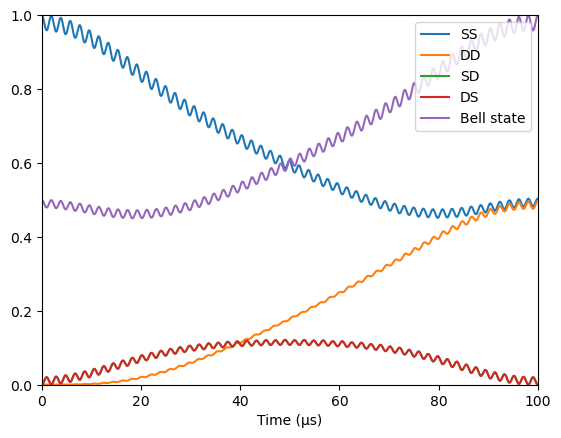

  0.139673 seconds (1.76 M allocations: 67.441 MiB, 9.65% gc time)
Bell-state fidelity: 0.9998161808711384 - 1.462547235324849e-9im
Electronic-Motional entanglement entropy: 0.0029198516661979408 + 0.0im


In [436]:
#################### Ion-chain ####################

chain = LinearChain(
    ions=[ion1, ion2], comfrequencies=(x=3e6,y=3e6,z=TRAPPING_FREQUENCY), selectedmodes=(;z=[1],)
)
    
#################### Lasers ####################

laser1 = Laser(pointing=[(1, 1.), (2, 1.)]) # <-- tuple = (integer: index of ion, float: amplitude at position of that ion (as fraction of predefined intensity))
laser1.œµ = xÃÇ
laser1.k = zÃÇ
intensity!(laser1, INTENSITY)
wavelength!(laser1, LASER_WAVELENGTH)

laser2 = Laser(pointing=[(1, 1.), (2, 1.)]) # So here, laser hitting each ion with full intensity
laser2.œµ = xÃÇ
laser2.k = zÃÇ
intensity!(laser2, INTENSITY)
wavelength!(laser2, LASER_WAVELENGTH)

d = 0
Œî_blue = TRAPPING_FREQUENCY + DETUNING - d 
Œî_red = -(TRAPPING_FREQUENCY + DETUNING - d )
laser1.Œî = Œî_blue # blue sideband
laser2.Œî = Œî_red; # red sideband

#################### Chamber ####################

chamber = Chamber(iontrap=chain, B=B_STRENGTH, Bhat=(xÃÇ + zÃÇ)/‚àö2, lasers=[laser1, laser2]);

#################### Hamiltonian, simulation ####################

h = hamiltonian(chamber, timescale=1e-6, lamb_dicke_order=1, rwa_cutoff=RWA_CUTOFF);
t_range = 0:GATE_TIME*1e-3:GATE_TIME
@time tout, sol = timeevolution.schroedinger_dynamic(t_range/timescale, œà0, h);

SS = ionprojector(chamber, "S", "S")
DD = ionprojector(chamber, "D", "D")
SD = ionprojector(chamber, "S", "D")
DS = ionprojector(chamber, "D", "S")
bell_state = dm((ca["S"] ‚äó ca["S"] + 1im * ca["D"] ‚äó ca["D"])/‚àö2) ‚äó one(vibrational_mode)

# compute expectation values
prob_SS = expect(SS, sol)  # ùîº(|S‚ü©|S‚ü©)
prob_DD = expect(DD, sol)  # ùîº(|D‚ü©|D‚ü©)
prob_SD = expect(SD, sol)  # ùîº(|S‚ü©|D‚ü©)
prob_DS = expect(DS, sol)  # ùîº(|D‚ü©|S‚ü©)
prob_bell = expect(bell_state, sol)  # ùîº((|S‚ü©|S‚ü© + i|D‚ü©|D‚ü©)/‚àö2)

# plot results
bs_fid = get_bell_state_fidelity(sol[end])
fig  = plt.figure()
plt.plot(tout, prob_SS, label="SS")
plt.plot(tout, prob_DD, label="DD")
plt.plot(tout, prob_SD, label="SD")
plt.plot(tout, prob_DS, label="DS")
plt.plot(tout, prob_bell, label="Bell state")
plt.xlim(tout[1], tout[end])
plt.ylim(0, 1)
plt.legend(loc=1)
plt.xlabel("Time (Œºs)");
plt.display(fig)



print("Bell-state fidelity: ", bs_fid, "\n")
print("Electronic-Motional entanglement entropy: ", get_entanglement_entropy(sol[end]), "\n")